In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction

This notebook demonstrates how to open common raster files (such as GeoTIFs and hdf5 files). Specifically, we will:

* Open an SRTM elevation file using `podpac.data.Rasterio`
* Open a SMAP file using `podpac.data.H5PY`

<small>*For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file.*</small>

## Setup

Make sure you have PODPAC installed with the **datatype** optional dependencies:

```
$ pip install podpac[datatype]
```


# How to open a raster file with PODPAC

The `podpac.data.Rasterio` node to read raster files such as GeoTIFs.

PODPAC wraps the [rasterio](https://rasterio.readthedocs.io/en/stable/) Python package (which wraps `gdal`) to read raster files.

## Reading SRTM GeoTIF elevation file

In [2]:
import podpac

# Get the file path from the podpac_examples repository
filename = '../../data/raster/n39_w107_1arc_v2.tif'

# Set up the PODPAC node to read this file
srtm = podpac.data.Rasterio(source=filename)

# The native coordinates of the dataset contain the resolution and bounds
srtm.native_coordinates

Coordinates (EPSG:4326)
	lat: UniformCoordinates1d(lat): Bounds[38.99999999999999, 39.99999999999999], N[3601], ctype['midpoint']
	lon: UniformCoordinates1d(lon): Bounds[-107.0, -106.0], N[3601], ctype['midpoint']

## Read and display raster data

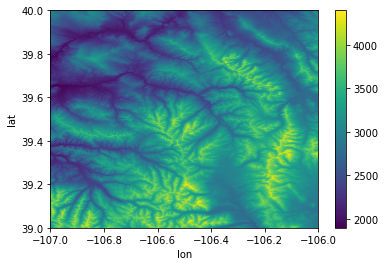

In [3]:
# retrieve all of the data at the native resolution into memory and plot
# this can take a little while on slower machines
output = srtm.eval(srtm.native_coordinates)
output.plot()
pass  # This line prevents "output.plot()" from displaying outputs

## Reading SMAP HDF5 file

PODPAC also wraps the [h5py](https://www.h5py.org/) Python package

This can be used to read `h5` files, which was the storage format used for SMAP, as an example.

This takes a little more work than reading the GeoTIF because `h5` files are more flexible. So, we have to:
1. Find the *keys* for the data we want
2. Tell PODPAC what are the coordinates of the data

The example below is relatively streamlined, but each new dataset may require some iteration. For example, you'll have to consider the: 
* Order of the coordinates 
    * (lat, lon) vs (lon, lat)
* The dimension of the array
    * Is this a 2D array with lat-lon dimensions? 
    * Is this a 3D array with lat-lon-time dimensions? 

### Quick Caveat

The example below shows how to integrate a specific dataset into PODPAC *and is signifigantly more complicated*.

We encourage users to contribute wrappers for datasets. We welcome pull requests to the `datalib` directory of the PODPAC repository.

**One of PODPAC's goals is to share the work of wrapping important datasets.**

In [4]:
import podpac

# Get the file path from the podpac_examples repostiory
filename = '../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5'

# Set up the PODPAC node to read this file. Notice, we specify that the number -9999 should be interpreted as a 'nan' in Python.
smap = podpac.data.H5PY(source=filename, nan_vals=[-9999])
smap

H5PY DataSource
	source: ../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5
	interpolation: nearest

## 1. Find the keys we need

In [5]:
smap.available_keys

['/Analysis_Data/sm_profile_analysis',
 '/Analysis_Data/sm_profile_analysis_ensstd',
 '/Analysis_Data/sm_rootzone_analysis',
 '/Analysis_Data/sm_rootzone_analysis_ensstd',
 '/Analysis_Data/sm_surface_analysis',
 '/Analysis_Data/sm_surface_analysis_ensstd',
 '/Analysis_Data/soil_temp_layer1_analysis',
 '/Analysis_Data/soil_temp_layer1_analysis_ensstd',
 '/Analysis_Data/surface_temp_analysis',
 '/Analysis_Data/surface_temp_analysis_ensstd',
 '/EASE2_global_projection',
 '/Forecast_Data/sm_profile_forecast',
 '/Forecast_Data/sm_rootzone_forecast',
 '/Forecast_Data/sm_surface_forecast',
 '/Forecast_Data/soil_temp_layer1_forecast',
 '/Forecast_Data/surface_temp_forecast',
 '/Forecast_Data/tb_h_forecast',
 '/Forecast_Data/tb_h_forecast_ensstd',
 '/Forecast_Data/tb_v_forecast',
 '/Forecast_Data/tb_v_forecast_ensstd',
 '/Observations_Data/tb_h_obs',
 '/Observations_Data/tb_h_obs_assim',
 '/Observations_Data/tb_h_obs_errstd',
 '/Observations_Data/tb_h_obs_time_sec',
 '/Observations_Data/tb_h_or

The keys suggests we want `cell_lat` and `cell_lon` keys for `lat` and `lon` coordinates

We are interested in surface soil moisture, so let's use the `/Analysis_Data/sm_surface_analysis` key for our data.

We'll make a new `DataSource` class that tells PODPAC how to interpret the coordinates and data from the file.

In [6]:
# Define a new class, inheriting from the PODPAC H5PY class
class SMAPH5(podpac.data.H5PY):
    # key for data values
    data_key = '/Analysis_Data/sm_surface_analysis'
    
    # Overwrite the 'get_native_coordinates' function of podpac.data.H5PY
    # to tell PODPAC how to assemble coordinates
    def get_native_coordinates(self):
        lat = self.dataset['cell_lat'][:, 0]
        lon = self.dataset['cell_lon'][0, :]
        
        # the order is important: lat = rows of array, lon = cols of array
        return podpac.Coordinates([lat, lon], dims=['lat', 'lon'])

In [7]:
# original example doesn't know where to find native_coordinates 
filename = '../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5'
smap = podpac.data.H5PY(source=filename, nan_vals=[-9999])
smap.native_coordinates

Coordinates (EPSG:4326)

In [8]:
# Make a PODPAC node to read this file
smap = SMAPH5(source=filename, nan_vals=[-9999])
smap.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.9533233642578, 179.9533233642578], N[3856], ctype['midpoint']

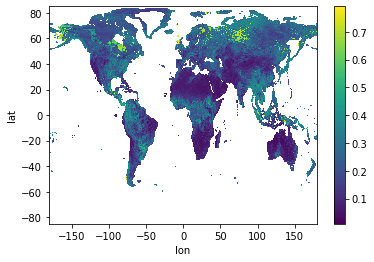

In [9]:
# retrieve all of the data at the native resolution into memory and plot
output = smap.eval(smap.native_coordinates)
output.plot()
pass

#  Example of automatic interpolation

Once the dataset is read through PODPAC, it can be re-interpolated automatically to a different coordinate system.

The default interpolation scheme is nearest-neighbor. 

Let's read **a subset of the SMAP data**, using nearest-neighbor interpolation **at the resolution of the SRTM file**.

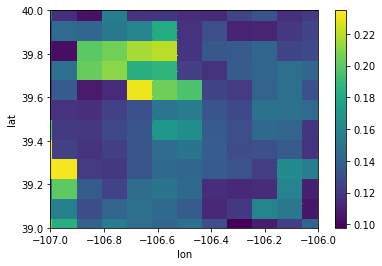

In [10]:
# evaluate the smap data at the native coordinates of the srtm elevation file
output = smap.eval(srtm.native_coordinates)
output.plot()
pass

In [11]:
# Note, the output is the same size as the SRTM data's native coordinates
print(output.shape) 
print(srtm.native_coordinates.shape)

(3601, 3601)
(3601, 3601)


## Alternate interpolation methods

Now let's use bilinear interpolation at the resolution of the SRTM file. 

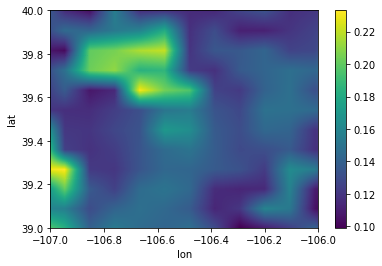

In [12]:
# Make a PODPAC node to read this file
smap = SMAPH5(source=filename, nan_vals=[-9999], interpolation="bilinear")
output = smap.eval(srtm.native_coordinates)
output.plot()
pass